In [29]:
import os
import random
from cProfile import label

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
from glob import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
vgg16_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

In [85]:
class DogCatDataset(Dataset):
    LABELS_DICT = {
        'dogs': 0,
        'cats': 1,
    }

    def __init__(self, path, lim=-1, aug=None):
        self.x = []
        self.y = []

        for label, val in self.LABELS_DICT.items():
            file_paths = glob(os.path.join(path, label, '*.jpg'))

            self.x.extend(file_paths)
            self.y.extend([val] * len(file_paths))

        shuffled_combined = list(zip(self.x, self.y))
        random.shuffle(shuffled_combined)
        self.x, self.y = zip(*shuffled_combined)

        self.x = self.x[:lim]
        self.y = self.y[:lim]

        self.aug = aug
        self.img_transform = transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(224),
            transforms.ToTensor(),

            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, idx):
        x = Image.open(self.x[idx])
        x = self.img_transform(x)
        return x, torch.tensor(self.y[idx]).float().unsqueeze(-1)

    def __len__(self):
        return len(self.x)


train_dataset = DogCatDataset("data/cats_and_dogs_classification/training_set", lim=500)
val_dataset = DogCatDataset("data/cats_and_dogs_classification/test_set", lim=200)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [7]:
for param in vgg16_model.parameters():
    param.requires_grad = False

In [8]:
vgg16_model.avgpool = nn.AdaptiveAvgPool2d(1)
vgg16_model.classifier = nn.Sequential(
    # nn.Linear(512, 128),
    # nn.BatchNorm1d(128),
    # nn.ReLU(True),
    # 
    # nn.Dropout(0.5),
    # nn.Linear(128, 1),
    # nn.Sigmoid()

    nn.Linear(512, 1),
    nn.Sigmoid(),
)

In [9]:
criterion = nn.BCELoss()
opt = optim.Adam(vgg16_model.parameters())

In [10]:
def measure_accuracy(_y: torch.Tensor, y: torch.Tensor) -> float:
    return (((_y >= 0.5) == y).sum() / y.shape[0]).item()

In [11]:
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [287]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

In [288]:
epochs = 5

for epoch in range(epochs):
    for x, y in train_dataloader:
        vgg16_model.train()

        _y = vgg16_model(x)
        loss = criterion(_y, y)

        train_losses.append(loss.item())
        train_accuracies.append(measure_accuracy(_y, y))

        opt.zero_grad()
        loss.backward()
        opt.step()

        print("done with train data")

        with torch.no_grad():
            vgg16_model.eval()

            for x_val, y_val in val_dataloader:
                _y_val = vgg16_model(x_val)
                val_losses.append(criterion(_y_val, y_val))
                val_accuracies.append(measure_accuracy(_y_val, y_val))

            print("done with validate data")


done with train data
done with validate data
done with train data
done with validate data
done with train data
done with validate data
done with train data
done with validate data
done with train data
done with validate data


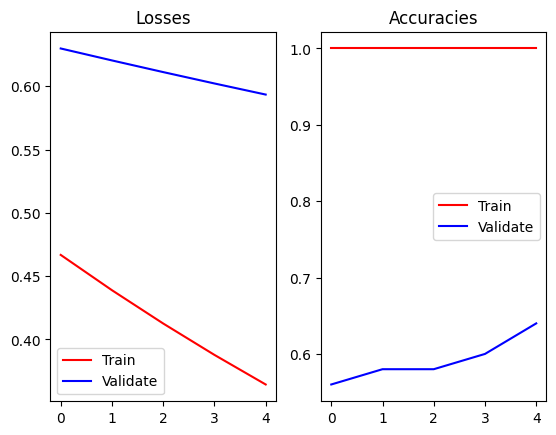

In [293]:
plt.subplot(121)
plt.plot(range(len(train_losses)), train_losses, label="Train", color='red')
plt.plot(range(len(val_losses)), val_losses, label="Validate", color='blue')
plt.title("Losses")
plt.legend()

plt.subplot(122)
plt.plot(range(len(train_accuracies)), train_accuracies, label="Train", color='red')
plt.plot(range(len(val_accuracies)), val_accuracies, label="Validate", color='blue')
plt.title("Accuracies")
plt.legend()

*RESNET BLOCKS DOWN HERE*

In [86]:
class ResLayer(nn.Module):
    def __init__(self, cin, cout, ksize=3):
        super().__init__()
        padding = (ksize - 1) / 2

        self.conv = nn.Sequential(
            nn.Conv2d(cin, cout, ksize),
            nn.BatchNorm2d(cout),
            nn.ReLU(),
            # nn.MaxPool2d(2),
        )

    def forward(self, x):
        return self.conv(x)
    
    
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1x64 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.MaxPool2d(2),
        )
        
        self.conv64 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
        )
        
        self.conv64x128 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1),
        )
        
        self.conv128 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.Conv2d(128, 128, 3, padding=1),
        )
        
        self.conv128x256 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3, padding=1),
        )
        self.conv256 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.Conv2d(256, 256, 3, padding=1),
        )
        
        self.conv256x512 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.MaxPool2d(2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 256, 1),
            nn.Sigmoid()
        )
        
    def repeater(self, mem):
        return F.max_pool2d(mem, 2).repeat(1, 2, 1, 1)
        
    def forward(self, x: torch.Tensor):
        x = self.conv1x64(x)
        mem = torch.clone(x)
        
        x = self.conv64(x)
        x += mem
        x = self.conv64(x)
        x += mem
        x = self.conv64(x)
        x += mem
        
        x = self.conv64x128(x)
        x += self.repeater(mem)
        mem = x.clone()
        
        x = self.conv128(x)
        x += mem
        x = self.conv128(x)
        x += mem
        x = self.conv128(x)
        x += mem
        
        x = self.conv128x256(x)
        x += self.repeater(mem)
        mem = x.clone()
        
        x = self.conv256(x)
        x += mem
        x = self.conv256(x)
        x += mem
        x = self.avgpool(x)
        
        x = self.fc(x)
        
        return x
    
    
    
resnet_model = ResNet()

tensor(0.7333, grad_fn=<BinaryCrossEntropyBackward0>)


KeyboardInterrupt: 

In [98]:
trn_losses = []
val_losses = []
trn_accuracies = []
val_accuracies = []


epochs = 2
criterion = nn.BCELoss()
opt = optim.Adam(resnet_model.parameters())
for epoch in range(epochs):
    for x, y in train_dataloader:
        x = x
        y = y

        _y = resnet_model(x)
        loss = criterion(_y, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        trn_losses.append(loss.item())
        
    trn_accuracies.append(measure_accuracy(_y, y))
    with torch.no_grad():
        for x_val, y_val in val_dataloader:
            _y_val = resnet_model(x_val)
            val_losses.append(criterion(_y_val, y_val))
            val_accuracies.append(measure_accuracy(_y, y))
            
    print(f'done with epoch {epoch}')

done with epoch 0
done with epoch 1


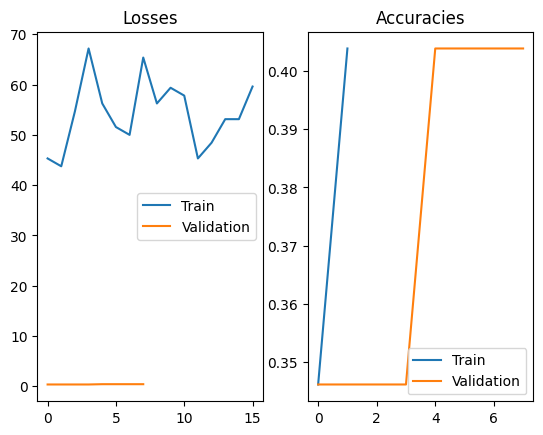

In [99]:
plt.subplot(121)
plt.title('Losses')
plt.plot(range(len(trn_losses)), trn_losses, label='Train')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation')
plt.legend()

plt.subplot(122)
plt.title('Accuracies')
plt.plot(range(len(trn_accuracies)), trn_accuracies, label='Train')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation')
plt.legend()